In [25]:
import os
import torch
import typing
from typing import List
import pandas as pd
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import cv2
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from __future__ import print_function

from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno

from torch.utils.tensorboard import SummaryWriter

from torchmetrics.detection.map import MeanAveragePrecision

from pprint import pprint

from tqdm import tqdm

from src.dataset import FoodDataset
from src.vis import read_image, show_image_coco

%matplotlib inline

In [9]:
RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

TRAIN_IMAGES_PATH = 'data/public_training_set_release_2.0/images/'
TRAIN_LABELS = 'data/public_training_set_release_2.0/annotations.json'

In [10]:
labels = COCO(TRAIN_LABELS)

loading annotations into memory...
Done (t=2.43s)
creating index...
index created!


In [15]:
# dir(labels)

In [12]:
img_ids = labels.getImgIds()
#184135
labels.imgToAnns[img_ids[1]]

[{'id': 185202,
  'image_id': 131097,
  'category_id': 1166,
  'segmentation': [[159.82125,
    345.04625,
    143.20375,
    355.79875,
    90.41875,
    337.22625,
    62.07125,
    330.38374999999996,
    44.47625,
    308.87874999999997,
    55.22875,
    279.55375,
    100.19375,
    285.41875,
    130.49625,
    291.28375,
    133.42875,
    267.82374999999996,
    126.58624999999999,
    229.70125,
    127.56375,
    210.15124999999998,
    158.84375,
    211.12875,
    172.52875,
    197.44375,
    133.42875,
    173.98375000000001,
    113.87875,
    148.56875,
    123.65374999999999,
    118.26625000000001,
    139.29375000000002,
    126.08625,
    144.18125,
    84.05375000000002,
    162.75375,
    78.18875000000001,
    180.34875,
    89.91875000000002,
    187.19125,
    115.33375000000001,
    207.71875,
    141.72625000000002,
    225.31375000000003,
    148.56875,
    232.15625,
    129.99625,
    238.99874999999997,
    111.42375000000001,
    238.02125,
    87.96375

In [13]:
len(labels.getCatIds())

498

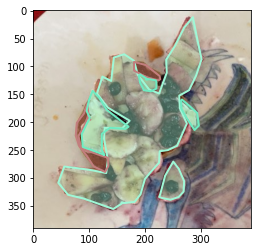

In [14]:
show_image_coco(img_ids[1], TRAIN_IMAGES_PATH, labels, True)

# Dataset

In [39]:
# a = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model_ft

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [56]:
model_ft.cpu().eval()
labels.loadImgs(img_ids[0])

raw_val = [train_ds[i] for i in range(0,10)]
trgt = [raw_val[i][1] for i in range(0,10)]
im_val = [torch.mul(255, raw_val[i][0]) for i in range(0,10)]
# im_val1 = [torch.from_numpy(im_val).float()]
res = model_ft(im_val)
pprint(res)

[{'boxes': tensor([[  0.0000, 295.9095, 426.0000, 295.9292],
        [  0.0000, 365.9462, 426.0000, 365.9689]], grad_fn=<StackBackward0>),
  'labels': tensor([1, 1]),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], grad_fn=<UnsqueezeBackward0>),
  'scores': tensor([1., 1.], grad_fn=<IndexBackward0>)},
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'masks': tensor([], size=(0, 1, 426, 426)),
  'scores': tensor([], grad_fn=<IndexBackw

In [58]:
metr = MeanAveragePrecision(
                box_format='xyxy',
                iou_thresholds=None,
                rec_thresholds=[1, 10, 100],
                class_metrics=False,
                )

metr.update(res, trgt)
pprint(metr.compute())

{'map': tensor(0.),
 'map_50': tensor(0.),
 'map_75': tensor(0.),
 'map_large': tensor(0.),
 'map_medium': tensor(-1.),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.),
 'mar_10': tensor(0.),
 'mar_100': tensor(0.),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.),
 'mar_medium': tensor(-1.),
 'mar_small': tensor(-1.)}


In [18]:
# create mask rcnn model
num_classes = 498
device = torch.device('cuda:0')

model_ft = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
in_features = model_ft.roi_heads.box_predictor.cls_score.in_features
model_ft.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
in_features_mask = model_ft.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
model_ft.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
model_ft.to(device)

for param in model_ft.parameters():
    param.requires_grad = True
for param in model_ft.backbone.parameters():
    param.requires_grad = False

In [47]:
train_ds = FoodDataset(TRAIN_IMAGES_PATH, TRAIN_LABELS)

data_loader = torch.utils.data.DataLoader(
    train_ds, batch_size=6, shuffle=True, num_workers=8,
    collate_fn=lambda x: tuple(zip(*x)))

params = [p for p in model_ft.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=5,
                                               gamma=0.1)

loading annotations into memory...
Done (t=2.31s)
creating index...
index created!


In [49]:
writer = SummaryWriter()

num_epochs = 1
model_ft.cuda()
for epoch in range(num_epochs):
    model_ft.train()

    for i_iter, (images, targets) in enumerate(tqdm(data_loader)):
        images = list(image.to(device) for image in images)
#         print(targets)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
#         print(targets)
#         break

        loss_dict = model_ft(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        
        writer.add_scalar('Loss/train', losses, i_iter)
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

100%|███████████████████████████████████████| 6661/6661 [49:02<00:00,  2.26it/s]
